In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

from disk_radon_test import *
from radon_transform import *

In [2]:
full_run = True

In [3]:
# Image parameters
image_height = 512
image_width = image_height
cmap = "gray"

In [4]:
xx, yy = np.mgrid[:image_height, :image_width]
center_x = image_width/2
center_y = image_height/2
SCALE = 45

In [5]:
def disk(x, y, radius):
    return x ** 2 + y ** 2 < radius ** 2

def p_function(x, y, a, delta_x, delta_y, radius):
    temp = np.array([disk(x-dx, y-dy, radius) for dx, dy in zip(delta_x, delta_y)])
    return (temp.T @ a).T

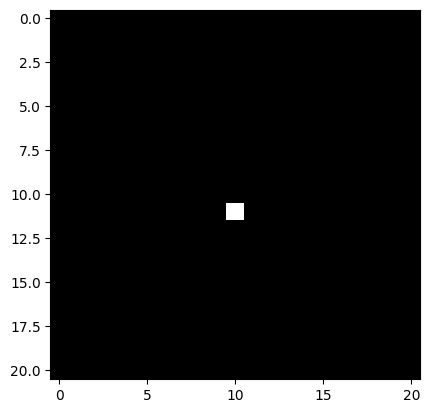

In [8]:
delta_x = np.array([1, 0.5, -0.5])
delta_y = 0.3 * np.array([0, 0.25, -0.5])
n = np.array([1, 0])
s = np.linspace(-2, 2, num=1000)
radius = 0.03
p_vals = p_function(xx-center_x, yy-center_y, np.ones(len(delta_x)), delta_x, delta_y, radius)
plt.imshow(p_vals[int(center_x-10):int(center_x+11), int(center_y-10):int(center_y+11)], cmap=cmap);

In [10]:
n = np.array([1, 0])
s = np.linspace(-2, 2, num=1000)

In [11]:
shifts = np.array(list(zip(delta_x, delta_y)))

In [12]:
disk = Disk(radius)
kwargs = {"support_disk_f": 50., "support_disk_t": 50.}
radon_gaussian = RadonTransform(disk, shifts, n.reshape(1,2), s, **kwargs)

In [13]:
%time
radon_p_vals = radon_gaussian.apply(np.ones(len(delta_x)))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.72 µs


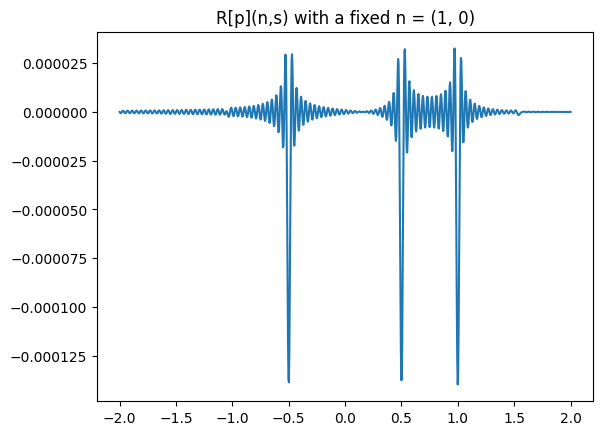

In [14]:
plt.plot(s, radon_p_vals.flatten())
plt.title(label="R[p](n,s) with a fixed n = (1, 0)");

In [15]:
thetas = np.linspace(0, 2 * np.pi, num=100)
s = np.linspace(-1, 1, num=120)

In [16]:
radon_gaussian2 = RadonTransform(disk, shifts, np.array(list(zip(np.cos(thetas), np.sin(thetas)))), s, **kwargs)

In [17]:
%%time
results = radon_gaussian2.apply(np.ones(len(delta_x)))

CPU times: user 10.9 s, sys: 96.1 ms, total: 11 s
Wall time: 821 ms


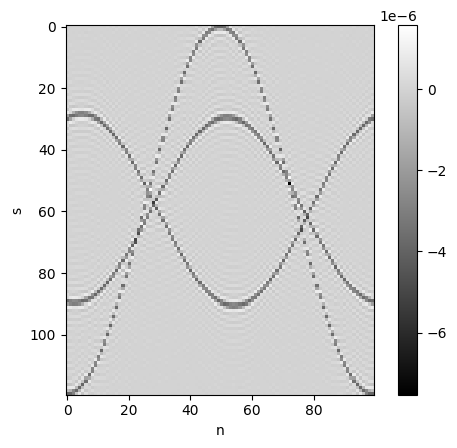

In [18]:
plt.imshow(results.T, cmap=cmap)
plt.colorbar()
plt.ylabel("s")
plt.xlabel("n");

In [20]:
%%time
resultsF = radon_gaussian2.applyF(np.ones(len(delta_x)))

CPU times: user 700 ms, sys: 44.2 ms, total: 744 ms
Wall time: 56 ms


In [28]:
n_runs = 500
delta = 100
eps = 1e-3
N = disk.support(**kwargs)*disk.supportF(**kwargs)/2.
freqs = np.arange(-N, N + 1).reshape(-1, 1)
alphas = np.ones(len(delta_x))

In [29]:
def time_run(k, radon_gaussian, time_step_1, time_step_2):
        start = time.time()
        resultsF = radon_gaussian.applyF(alphas)
        end = time.time()
        time_step_1[k] = end - start

        start = time.time()
        results = radon_gaussian.apply(alphas)
        end = time.time()
        time_step_2[k] = end - start - time_step_1[k]

In [30]:
if full_run:
    time_step_1 = np.zeros(delta)
    time_step_2 = np.zeros(delta)
    k = 0
    for run in tqdm.trange(n_runs - delta, n_runs):
        thetas = np.linspace(0, 2 * np.pi, num=run)
        s = np.linspace(-1, 1, num=10)
        radon_gaussian = RadonTransform(disk, shifts, np.array(list(zip(np.cos(thetas), np.sin(thetas)))), s, **kwargs)
        time_run(k, radon_gaussian, time_step_1, time_step_2)
        k += 1

100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


In [31]:
def plot_benchmark(time_step_1, time_step_2, n_runs, delta, title):
    xs = np.arange(n_runs-delta, n_runs)
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    plt.scatter(xs, time_step_1, label="step 1")
    plt.scatter(xs, time_step_2, label="step 2")
    m_s1, b_s1 = np.polyfit(xs, time_step_1, 1)
    m_s2, b_s2 = np.polyfit(xs, time_step_2, 1)
    plt.plot(xs, m_s1*xs+b_s1)
    plt.plot(xs, m_s2*xs+b_s2)
    plt.legend()
    plt.title(label=title)
    plt.show()
    fig.savefig("../../../outputs/" + title + ".png")

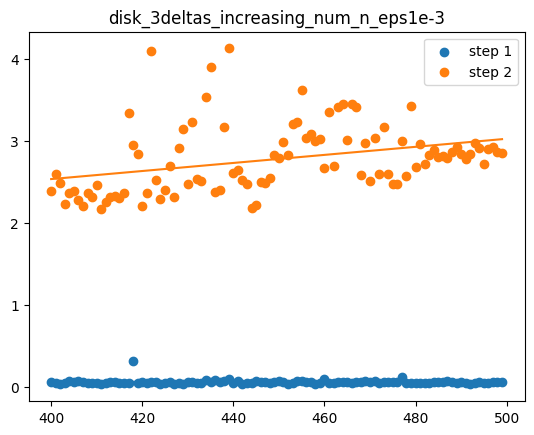

In [32]:
if full_run:
    plot_benchmark(time_step_1, time_step_2, n_runs, delta, "disk_3deltas_increasing_num_n_eps1e-3")

In [33]:
if full_run:
    time_step_1 = np.zeros(delta)
    time_step_2 = np.zeros(delta)
    k = 0
    for run in tqdm.trange(n_runs - delta, n_runs):
        thetas = np.linspace(0, 2 * np.pi, num=30)
        s = np.linspace(-1, 1, num=run)
        radon_gaussian = RadonTransform(disk, shifts, np.array(list(zip(np.cos(thetas), np.sin(thetas)))), s, **kwargs)
        time_run(k, radon_gaussian, time_step_1, time_step_2)
        k += 1

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


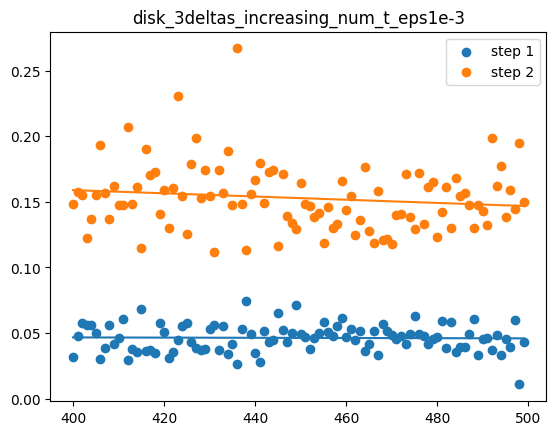

In [34]:
if full_run:
    plot_benchmark(time_step_1, time_step_2, n_runs, delta, "disk_3deltas_increasing_num_t_eps1e-3")